# HDF5 python #

This jupter script is for reading and converting hdf5 files


In [6]:
import h5py
f = h5py.File('D:\CUHK\Data_from_zcao\struct03_snap38.h5', 'r')
list(f.keys())


['bounded_region',
 'clump_vertex_coord',
 'gas_density',
 'grav_pot',
 'i_mag_field',
 'i_velocity',
 'j_mag_field',
 'j_velocity',
 'k_mag_field',
 'k_velocity']

In [7]:
import numpy as np
B_i = np.array(f['i_mag_field'])
B_j = np.array(f['j_mag_field'])
B_k = np.array(f['k_mag_field'])
print(B_i.shape, B_j.shape, B_k.shape[1])
type(B_i)

(31, 130, 25) (31, 130, 25) 130


numpy.ndarray

NameError: name 'B_mag' is not defined

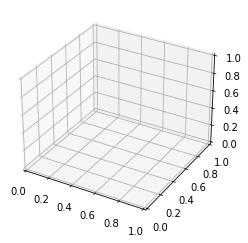

In [8]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

B_mag = np.sqrt(B_i*B_i + B_j*B_j + B_k*B_k)
fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([B_mag.shape[0], B_mag.shape[1], B_mag.shape[2]])


x, y, z = np.meshgrid(np.linspace(1, B_i.shape[1], B_i.shape[1]),
                      np.linspace(1, B_i.shape[0], B_i.shape[0]),
                      np.linspace(1, B_i.shape[2], B_i.shape[2]))
# this is a strange thing: the mesh grid data is not mathched with the original order
# x, y, z = np.meshgrid(31, 130, 25) ====> x.shape = (130, 31, 25) 

ax.quiver(x, y, z, B_i, B_j, B_k, length=0.001)

plt.show('agg')

## draw the 3d Isosurface 

$$|B| = \sqrt{B_iB^i}$$

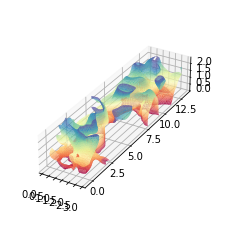

In [ ]:
from skimage.measure import marching_cubes_lewiner
B_mag = np.sqrt(B_i*B_i + B_j*B_j + B_k*B_k)
iso_val=np.mean(B_mag)
verts, faces, _, _ = marching_cubes_lewiner(B_mag, iso_val, spacing=(0.1, 0.1, 0.1))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([B_mag.shape[0], B_mag.shape[1], B_mag.shape[2]])
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], cmap='Spectral',
                lw=1)
plt.show('agg')


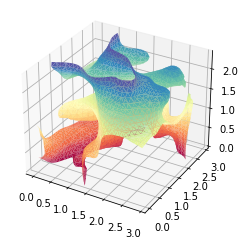

In [ ]:
B_mag_masked = B_mag[0:30, 50:80, 0:25]
iso_val=np.mean(B_mag_masked)
verts, faces, _, _ = marching_cubes_lewiner(B_mag_masked, iso_val, spacing=(0.1, 0.1, 0.1))
# verts.shape
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([B_mag_masked.shape[0], B_mag_masked.shape[1], B_mag_masked.shape[2]])
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], cmap='Spectral',
                lw=1)
plt.show('agg')

In [1]:
import pyvista as pv
import numpy as np
import h5py
pv.set_jupyter_backend('pythreejs') 


f = h5py.File('D:\CUHK\Data_from_zcao\struct03_snap38.h5', 'r')
B_i = np.array(f['i_mag_field'])
B_j = np.array(f['j_mag_field'])
B_k = np.array(f['k_mag_field'])

values = B_i
# values.shape

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(values.shape)

# Edit the spatial reference
grid.origin = (0, 0, 0)  # The bottom left corner of the data set
grid.spacing = (1, 1, 1)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.point_data["values"] = values.flatten(order="F")  # Flatten the array!

# Now plot the grid!
grid.plot(show_edges=False)

contours = grid.contour(np.linspace(np.min(B_i), np.max(B_i), 5))

p = pv.Plotter()
p.add_mesh(grid.outline(), color="k")
p.add_mesh(contours, opacity=0.25, clim=[0, 200])

p.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…

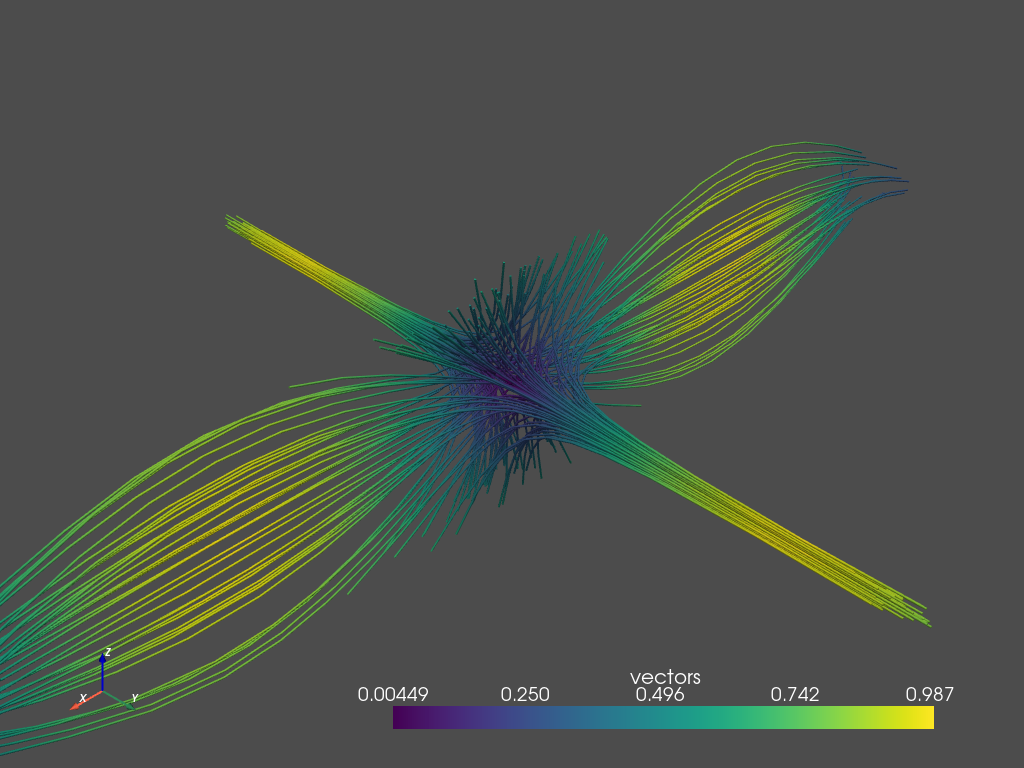

In [ ]:
nx = 20
ny = 15
nz = 5

origin = (-(nx - 1)*0.1/2, -(ny - 1)*0.1/2, -(nz - 1)*0.1/2)
mesh = pv.UniformGrid((nx, ny, nz), (.1, .1, .1), origin)
x = mesh.points[:, 0]
y = mesh.points[:, 1]
z = mesh.points[:, 2]
vectors = np.empty((mesh.n_points, 3))

vectors[:, 0] = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
vectors[:, 1] = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
vectors[:, 2] = (np.sqrt(3.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
                 np.sin(np.pi * z))

mesh['vectors'] = vectors
stream, src = mesh.streamlines('vectors', return_source=True,
                               terminal_speed=0.0, n_points=200,
                               source_radius=0.1)
cpos = [(1.2, 1.2, 1.2), (-0.0, -0.0, -0.0), (0.0, 0.0, 1.0)]
pv.set_jupyter_backend('none')
stream.tube(radius=0.0015).plot(cpos=cpos)

In [ ]:

mesh = pv.UniformGrid(B_i.shape, (1, 1, 1), (0,0,0))
x = mesh.points[:, 0]
y = mesh.points[:, 1]
z = mesh.points[:, 2]
vectors = np.empty((mesh.n_points, 3))
vectors[:, 0] = B_i.flatten()
vectors[:, 1] = B_j.flatten()
vectors[:, 2] = B_k.flatten()

mesh['vectors'] = vectors
stream, src = mesh.streamlines('vectors', return_source=True,
                               terminal_speed=0, n_points=100,
                               source_radius=15)
pv.set_jupyter_backend('none')
p = pv.Plotter()
p.add_mesh(mesh.outline(), color="k")
p.add_mesh(stream.tube(radius=0.1), scalars="vectors", lighting=False)
p.show()

NameError: name 'pv' is not defined